In [1]:
import cv2
import joblib
import numpy as np
import os
import glob
import mahotas
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [2]:
# Extract Features

def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(0)
    return haralick

def fd_histogram(image, bins=8):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [3]:
dataset_path = './'
fixed_size = (300, 300)
bins = 8

In [4]:
global_features = []
labels = []

In [5]:
train_labels = os.listdir(dataset_path)
train_labels.sort()

In [6]:
train_labels

['ANN copy 2.ipynb',
 'ANN copy 3.ipynb',
 'ANN copy.ipynb',
 'ANN.ipynb',
 'ANN_NEW_GLCM.ipynb',
 'Bacterialblight',
 'Brownspot',
 'Healthy',
 'LeafBlast',
 'TEST',
 'alot.keras',
 'alot_gg.keras',
 'alot_gg_h.keras',
 'alot_v2.keras',
 'alot_v3.keras',
 'bl.png',
 'blight.jpeg',
 'healthy-1.jpg',
 'healthy-2.png',
 'healthy-3.jpg',
 'image.png',
 'main - Copy copy 2.ipynb',
 'main - Copy copy.ipynb',
 'main.ipynb',
 'model.keras',
 'model_v2.keras',
 'scaler_alot.pkl',
 'scaler_alot_gg.pkl',
 'scaler_alot_gg_h.pkl',
 'scaler_alot_v2.pkl',
 'scaler_alot_v3.pkl',
 'scaler_v2.save',
 'svc_model.pkl']

In [7]:
for training_name in train_labels:
    dir = os.path.join(dataset_path, training_name)
    current_label = training_name
    
    if current_label in ['Bacterialblight', 'Brownspot','Healthy','LeafBlast']:
        print(current_label)
        file_list = glob.glob(os.path.join(dir, "*"))
        print(file_list)
    
        for file in file_list:
            image = cv2.imread(file)
            if image is None: continue
        
            image = cv2.resize(image, fixed_size)

            fv_hu_moments = fd_hu_moments(image)
            fv_haralick   = fd_haralick(image)
            fv_histogram  = fd_histogram(image, bins)
            
            global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

            labels.append(current_label)
            global_features.append(global_feature)

Bacterialblight
['./Bacterialblight\\BACTERAILBLIGHT3_001.jpg', './Bacterialblight\\BACTERAILBLIGHT3_002.jpg', './Bacterialblight\\BACTERAILBLIGHT3_003.jpg', './Bacterialblight\\BACTERAILBLIGHT3_004.jpg', './Bacterialblight\\BACTERAILBLIGHT3_005.jpg', './Bacterialblight\\BACTERAILBLIGHT3_006.jpg', './Bacterialblight\\BACTERAILBLIGHT3_007.jpg', './Bacterialblight\\BACTERAILBLIGHT3_008.jpg', './Bacterialblight\\BACTERAILBLIGHT3_009.jpg', './Bacterialblight\\BACTERAILBLIGHT3_010.jpg', './Bacterialblight\\BACTERAILBLIGHT3_011.jpg', './Bacterialblight\\BACTERAILBLIGHT3_012.jpg', './Bacterialblight\\BACTERAILBLIGHT3_013.jpg', './Bacterialblight\\BACTERAILBLIGHT3_014.jpg', './Bacterialblight\\BACTERAILBLIGHT3_015.jpg', './Bacterialblight\\BACTERAILBLIGHT3_016.jpg', './Bacterialblight\\BACTERAILBLIGHT3_017.jpg', './Bacterialblight\\BACTERAILBLIGHT3_018.jpg', './Bacterialblight\\BACTERAILBLIGHT3_019.jpg', './Bacterialblight\\BACTERAILBLIGHT3_020.jpg', './Bacterialblight\\BACTERAILBLIGHT3_021.jp

label
LeafBlast          2589
Brownspot          2533
Bacterialblight    1994
Healthy            1914
Name: count, dtype: int64


<Axes: xlabel='label'>

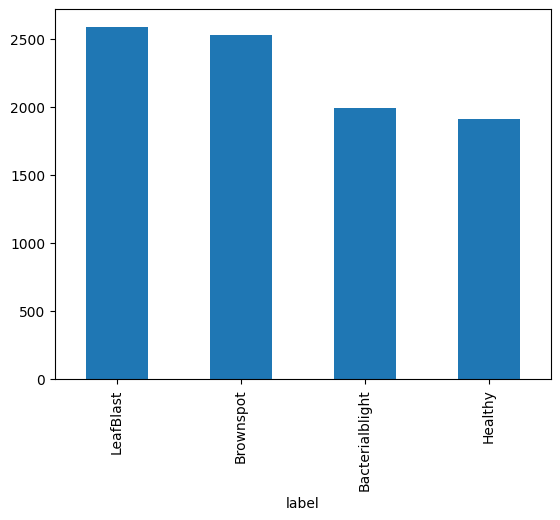

In [8]:
df = pd.DataFrame({"label": labels})

print(df["label"].value_counts())

df["label"].value_counts().plot(kind="bar")

In [9]:
set(labels)

{'Bacterialblight', 'Brownspot', 'Healthy', 'LeafBlast'}

In [10]:
len(global_features)

9030

In [11]:
le = LabelEncoder()
target = le.fit_transform(labels)

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(
    rescaled_features, target, test_size=0.2, random_state=42, stratify=target
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [14]:
num_classes = len(['Bacterialblight', 'Brownspot','Healthy','LeafBlast'])
y_train_hot = to_categorical(y_train, num_classes)
y_val_hot   = to_categorical(y_val, num_classes)
y_test_hot  = to_categorical(y_test, num_classes)

In [15]:
model = Sequential()
input_dim = rescaled_features.shape[1]

model.add(Dense(512, activation='relu', input_shape=(input_dim,)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

c:\Users\Allen\Documents\Python Env\environments\computer_fusion\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
OPTIMIZER = Adam(learning_rate=0.001)

In [17]:
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

In [18]:
history = model.fit(
    X_train, y_train_hot,
    epochs=20,
    batch_size=20,
    validation_data=(X_val, y_val_hot),
    verbose=1
)

Epoch 1/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7580 - loss: 0.5926 - val_accuracy: 0.8516 - val_loss: 0.3507
Epoch 2/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8427 - loss: 0.3773 - val_accuracy: 0.8760 - val_loss: 0.3072
Epoch 3/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8558 - loss: 0.3490 - val_accuracy: 0.8882 - val_loss: 0.2825
Epoch 4/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8675 - loss: 0.3247 - val_accuracy: 0.8726 - val_loss: 0.2995
Epoch 5/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8746 - loss: 0.3044 - val_accuracy: 0.8926 - val_loss: 0.2528
Epoch 6/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8785 - loss: 0.2922 - val_accuracy: 0.8893 - val_loss: 0.2655
Epoch 7/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8749 - loss: 0.3083 - val_accuracy: 0.8915 - val_loss: 0.2624
Epoch 8/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8869 - loss: 0.2783 - val_accuracy: 0.

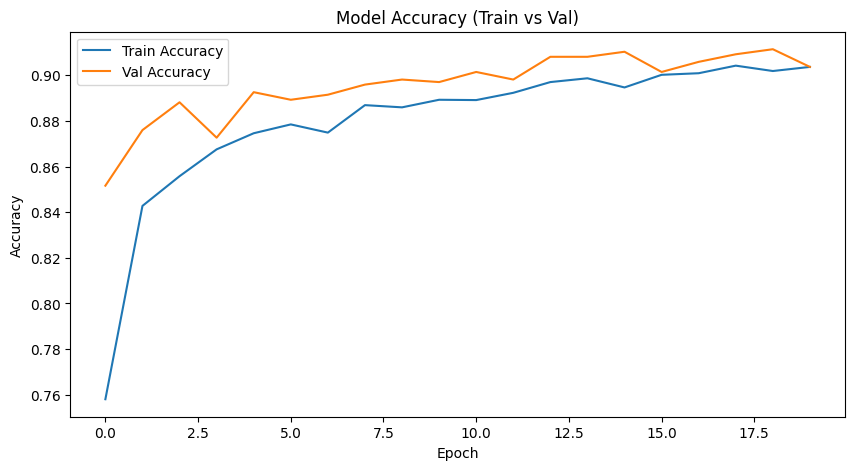

In [19]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy (Train vs Val)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [20]:
results = model.evaluate(X_test, y_test_hot, batch_size=32)
print(f"\nTest Loss     : {results[0]:.4f}")
print(f"Test Accuracy : {results[1]*100:.2f}%")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8970 - loss: 0.2638

Test Loss     : 0.2638
Test Accuracy : 89.70%


In [21]:
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_hot, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [22]:
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

                 precision    recall  f1-score   support

Bacterialblight       0.98      1.00      0.99       200
      Brownspot       0.93      0.93      0.93       253
        Healthy       0.76      0.90      0.82       191
      LeafBlast       0.92      0.79      0.85       259

       accuracy                           0.90       903
      macro avg       0.90      0.90      0.90       903
   weighted avg       0.90      0.90      0.90       903



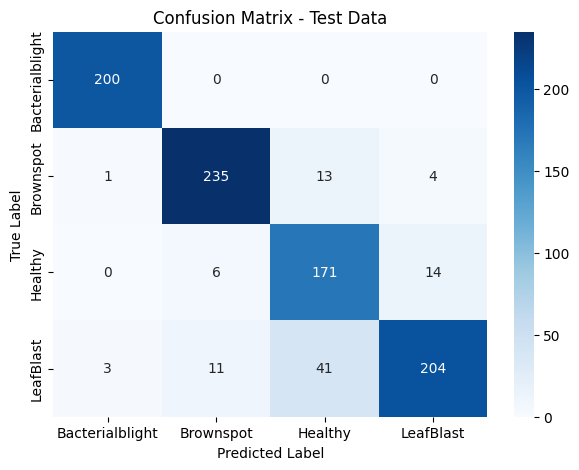

In [23]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [24]:
def predict_image(path, model, scaler):
    img = cv2.imread(path)
    img = cv2.resize(img, (300, 300))

    fv_hu_moments = fd_hu_moments(img)
    fv_haralick   = fd_haralick(img)
    fv_histogram  = fd_histogram(img, bins)

        # Combine
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    
    rescaled_features = scaler.transform([global_feature])
    
    pred = model.predict(rescaled_features)

    return pred

In [25]:
for cls, enc in zip(le.classes_, range(len(le.classes_))):
    print(f"{cls} → {enc}")

Bacterialblight → 0
Brownspot → 1
Healthy → 2
LeafBlast → 3


In [26]:
huh = ['Bacterialblight', 'Brownspot','Healthy','LeafBlast']

In [27]:
pred = predict_image('TEST/Brownspot/brown_val (2).jpg', model, scaler)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [28]:
idx = np.argmax(pred, axis=1)[0]
print(huh[idx])

Brownspot


In [29]:
MODEL_PATH = 'model_3h.keras'
SCALER_PATH = 'scaler_3h.pkl'

In [30]:
model.save(MODEL_PATH)

In [31]:
joblib.dump(scaler, SCALER_PATH)

['scaler_3h.pkl']

In [32]:

# model_loader = load_model('model_v2.keras')

# scaler_loader = joblib.load('scaler_v2.save')


model_loader = load_model('alot.keras')

scaler_loader = joblib.load('scaler_alot.pkl')

In [33]:
pred222 = predict_image('TEST/Brownspot/brown_val (21).jpg', model_loader, scaler_loader)

idx2 = np.argmax(pred222, axis=1)[0]
print(huh[idx2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Brownspot
